In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,LSTM, GRU, SimpleRNN
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers import ConvLSTM2D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential
from keras.losses import mean_squared_error
from keras.backend import sign
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from sklearn.metrics import accuracy_score


2022-04-23 10:32:43.822379: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-23 10:32:43.822403: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Data Processing

In [2]:
# read data from AEP hourly
fpath='eye_state.csv'
df=pd.read_csv(fpath, header=0, names=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', 'Target'])
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Target
0,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
1,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
2,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
3,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0
4,4321.03,4004.62,4284.10,4153.33,4345.64,4587.18,4093.33,4616.92,4202.56,4232.82,4209.74,4281.03,4628.21,4389.74,0


In [3]:
# check missing data in file
df.isna().sum()

1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
Target    0
dtype: int64

In [4]:
# check missing data in file
df.isna().sum()

1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
Target    0
dtype: int64

In [5]:
# normalize the data
scaler = StandardScaler() 
scaled_values = scaler.fit_transform(df) 
df.loc[:,:] = scaled_values
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Target
0,0.001085,-0.112049,0.671413,-0.003111,0.008909,-0.019610,-0.002817,0.782290,-0.003771,-0.122092,0.138509,0.006194,0.014578,-0.005489,-0.902395
1,0.002316,-0.067427,0.705851,-0.001637,-0.138765,-0.020663,-0.002930,0.484938,-0.005213,-0.243509,0.111515,0.067815,0.011185,-0.004618,-0.902395
2,0.002730,0.044018,0.729035,-0.001734,0.053240,-0.021016,-0.002817,0.502349,-0.000649,0.106812,0.220021,0.203573,0.014156,-0.003399,-0.902395
3,0.001698,0.044018,0.636750,-0.002620,0.171264,-0.019610,-0.003152,0.397201,-0.003771,0.335979,0.274274,0.216090,0.014578,-0.003052,-0.902395
4,-0.000356,-0.112049,0.451955,-0.002227,0.112252,-0.019436,-0.003710,0.029522,-0.007614,0.039533,0.192762,0.043263,0.010763,-0.004532,-0.902395


In [6]:
# prepare df for target results
y=pd.DataFrame({'Target':df['Target']})
y['Target']=y['Target'].astype(int)
y.head()

,Target
0,0
1,0
2,0
3,0
4,0


In [7]:
# remove results from the input df
df = df.drop(columns=['Target'])
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.001085,-0.112049,0.671413,-0.003111,0.008909,-0.019610,-0.002817,0.782290,-0.003771,-0.122092,0.138509,0.006194,0.014578,-0.005489
1,0.002316,-0.067427,0.705851,-0.001637,-0.138765,-0.020663,-0.002930,0.484938,-0.005213,-0.243509,0.111515,0.067815,0.011185,-0.004618
2,0.002730,0.044018,0.729035,-0.001734,0.053240,-0.021016,-0.002817,0.502349,-0.000649,0.106812,0.220021,0.203573,0.014156,-0.003399
3,0.001698,0.044018,0.636750,-0.002620,0.171264,-0.019610,-0.003152,0.397201,-0.003771,0.335979,0.274274,0.216090,0.014578,-0.003052
4,-0.000356,-0.112049,0.451955,-0.002227,0.112252,-0.019436,-0.003710,0.029522,-0.007614,0.039533,0.192762,0.043263,0.010763,-0.004532


In [8]:
# change input format from df to array
df=np.array(df)
y=np.array(y)

# split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3)
print("Input shape ", df.shape)
print("Train data shapes ", X_train.shape,", ", y_train.shape) 
print("Test data shapes ", X_test.shape,", ", y_test.shape)

Input shape  (14979, 14)
Train data shapes  (10485, 14) ,  (10485, 1)
Test data shapes  (4494, 14) ,  (4494, 1)


In [9]:
# change input dimensions to 3 for LSTM input
X_train = np.reshape(X_train, (10485, 14, 1))
X_test = np.reshape(X_test, (4494, 14, 1))
print("Input shape ", df.shape)
print("Train data shapes ", X_train.shape,", ", y_train.shape) 
print("Test data shapes ", X_test.shape,", ", y_test.shape)

Input shape  (14979, 14)
Train data shapes  (10485, 14, 1) ,  (10485, 1)
Test data shapes  (4494, 14, 1) ,  (4494, 1)


# General Functions

In [10]:
def get_result(model, X_test, y_test, model_name="Test"): 
    print(f"Model - {model_name}:")
    
    predictions = model.predict(X_test)
    y_test=y_test.astype('int32')
    acc=accuracy_score(y_test, (predictions> 0.5).astype(int))
    print("Accuracy Score:",acc)
    return model.predict(X_test)

def plot_predictions(test, predicted, title="Test", xLabel="Test", yLabel="Test", realLabel="Test", predictedLabel="Test"):
    plt.figure(figsize=(20,8))
    plt.rcParams.update({'font.size': 18})
    plt.plot(test, color='red',label=realLabel)
    plt.plot(predicted, alpha=0.7, color='blue',label=predictedLabel)
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.legend()
    plt.show()

n_hidden_first = 50n_hidden_first = 50### Models in Functions

In [16]:
n_hidden_first = 50

In [11]:
def lstm(X_train,y_train):
    lstm_model = Sequential()

    lstm_model.add(LSTM(128, input_shape=(X_train.shape[1], 1)))
    lstm_model.add(Dropout(0.15))
    lstm_model.add(Dense(1, activation="sigmoid"))

    lstm_model.summary()
    adam_modified = optimizers.Adam(learning_rate=0.005, beta_1=0.7, beta_2=0.9, amsgrad=False)
    # train LSTM model
    lstm_model.compile(loss="binary_crossentropy", optimizer=adam_modified, metrics=["accuracy"])
    lstm_model.fit(X_train, y_train, epochs=40)
    return lstm_model

In [17]:
def stacked_lstm(X_train,y_train):
# build Stacked_LSTM model
    s_lstm_model = Sequential()

    s_lstm_model.add(LSTM(n_hidden_first,return_sequences=True,activation="tanh", input_shape=(X_train.shape[1],1)))
    s_lstm_model.add(Dropout(0.15))
    s_lstm_model.add(LSTM(128, return_sequences=False))
    s_lstm_model.add(Dropout(0.2))
    s_lstm_model.add(Dense(1, activation="sigmoid"))

    s_lstm_model.summary()
    adam_modified = optimizers.Adam(learning_rate=0.005, beta_1=0.7, beta_2=0.9, amsgrad=False)
    # train LSTM model
    s_lstm_model.compile(loss="binary_crossentropy", optimizer=adam_modified, metrics=["accuracy"])
    s_lstm_model.fit(X_train, y_train, epochs=40)
    return s_lstm_model

In [12]:
def gru(X_train,y_train):
    # build GRU model
    gru_model = Sequential()

    gru_model.add(GRU(X_train.shape[1],activation="tanh", input_shape=(X_train.shape[1],1)))
    gru_model.add(Dropout(0.15))

    gru_model.add(Dense(1, activation="sigmoid"))

    gru_model.summary()
    adam_modified = optimizers.Adam(learning_rate=0.005, beta_1=0.7, beta_2=0.9, amsgrad=False)
    # train LSTM model
    gru_model.compile(loss="binary_crossentropy", optimizer=adam_modified, metrics=["accuracy"])
    gru_model.fit(X_train, y_train, epochs=40)
    return gru_model

In [13]:
def rnn(X_train,y_train):
    rnn_model = Sequential()

    rnn_model.add(SimpleRNN(X_train.shape[1],activation="tanh", input_shape=(X_train.shape[1],1)))
    rnn_model.add(Dropout(0.15))

    rnn_model.add(Dense(1, activation="sigmoid"))

    rnn_model.summary()
    adam_modified = optimizers.Adam(learning_rate=0.005, beta_1=0.7, beta_2=0.9, amsgrad=False)
    # train LSTM model
    rnn_model.compile(loss="binary_crossentropy", optimizer=adam_modified, metrics=["accuracy"])
    rnn_model.fit(X_train, y_train, epochs=40)

    return rnn_model


In [29]:
def cnn(X_train,y_train):
    cnn_model = Sequential()
    cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)))
    cnn_model.add(MaxPooling1D(pool_size=3))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(30, activation='relu'))
    cnn_model.add(Dense(10, activation='relu'))
    cnn_model.add(Dense(1))
    cnn_model.summary()
    cnn_model.compile(optimizer="adam",loss="MSE")
    cnn_model.fit(X_train, y_train, epochs=50)
    return cnn_model

In [36]:
def cnn_lstm(X_train,y_train):
    n_seq = 1
    X_train_reshaped = X_train.reshape((X_train.shape[0], n_seq, X_train.shape[1], 1))

    cnn_lstm_model = Sequential()
    cnn_lstm_model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'), input_shape=(None, X_train.shape[1],1)))
    cnn_lstm_model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    cnn_lstm_model.add(TimeDistributed(Flatten()))
    cnn_lstm_model.add(LSTM(15, activation='relu'))
    cnn_lstm_model.add(Dense(1))

    cnn_lstm_model.summary() 
    cnn_lstm_model.compile(optimizer="adam",loss="MSE")
    cnn_lstm_model.fit(X_train_reshaped, y_train, epochs=50)
    return cnn_lstm_model

In [40]:
def convlstm(X_train,y_train):
    n_seq = 1
    n_features = 1
    X_train_reshaped = X_train.reshape((X_train.shape[0], n_seq, 1, X_train.shape[1], n_features))

    conv_lstm_model = Sequential()
    conv_lstm_model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, X_train.shape[1], n_features)))
    conv_lstm_model.add(Flatten())
    conv_lstm_model.add(Dense(20, activation='relu'))
    conv_lstm_model.add(Dense(10, activation='relu'))
    conv_lstm_model.add(Dense(1)) 
    conv_lstm_model.summary()

    conv_lstm_model.compile(optimizer="adam",loss="MSE")
    conv_lstm_model.fit(X_train_reshaped, y_train, epochs=50)
    return conv_lstm_model


# Training and fitting models

In [14]:
# build LSTM model
lstm_model=lstm(X_train,y_train)
lstm_predictions = get_result(lstm_model, X_test, y_test, "LSTM")
#plot_predictions(y_test, lstm_predictions, "LSTM model", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
328/328 [==============================] - 4s 8ms/step - loss: 0.6758 - accuracy: 0.5669
Epoch 2/40
328/328 [==============================] - 2s 7ms/step - loss: 0.6597 - accuracy: 0.5933
Epoch 3/40
328/328 [==============================] - 2s 7ms/step - loss: 0.6306 - accuracy: 0.6338
Epoch 4/40
328/3

In [15]:
# build Stacked_LSTM model
s_lstm_model = stacked_lstm(X_train,y_train)
s_lstm_predictions = get_result(s_lstm_model, X_test, y_test, "Stacked LSTM")
#plot_predictions(y_test, s_lstm_predictions, "Stacked LSTM model", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 14, 14)            896       
                                                                 
 dropout_1 (Dropout)         (None, 14, 14)            0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               73216     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 74,241
Trainable params: 74,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
328/328 [==============================

In [17]:
gru_model=gru(X_train,y_train)
gru_predictions = get_result(gru_model, X_test, y_test, "GRU")
#plot_predictions(y_test, gru_predictions, "GRU model", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 14)                714       
                                                                 
 dropout_4 (Dropout)         (None, 14)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 15        
                                                                 
Total params: 729
Trainable params: 729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
328/328 [==============================] - 3s 5ms/step - loss: 0.6774 - accuracy: 0.5641
Epoch 2/40
328/328 [==============================] - 2s 6ms/step - loss: 0.6641 - accuracy: 0.5874
Epoch 3/40
328/328 [==============================] - 2s 5ms/step - loss: 0.6588 - accuracy: 0.5966
Epoch 4/40
328/328 [

In [18]:
# build RNN model
rnn_model=rnn(X_train,y_train)
rnn_predictions = get_result(rnn_model, X_test, y_test, "RNN")
#plot_predictions(y_test, rnn_predictions, "RNN model", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 14)                224       
                                                                 
 dropout_5 (Dropout)         (None, 14)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 15        
                                                                 
Total params: 239
Trainable params: 239
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
328/328 [==============================] - 1s 2ms/step - loss: 0.6789 - accuracy: 0.5676
Epoch 2/40
328/328 [==============================] - 1s 2ms/step - loss: 0.6689 - accuracy: 0.5758
Epoch 3/40
328/328 [==============================] - 1s 2ms/step - loss: 0.6562 - accuracy: 0.5963
Epoch 4/40
328/328 [

In [31]:
# build CNN model
cnn_model=cnn(X_train,y_train)
cnn_predictions = get_result(cnn_model, X_test, y_test, "CNN")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 12, 64)            256       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 30)                7710      
                                                                 
 dense_14 (Dense)            (None, 10)                310       
                                                                 
 dense_15 (Dense)            (None, 1)                 11        
                                                      

In [37]:
# build CNN-LSTM model
n_seq=1
cnn_lstm_model=cnn_lstm(X_train,y_train)
cnn_lstm_predictions = get_result(cnn_lstm_model, X_test.reshape((X_test.shape[0], n_seq, X_test.shape[1], 1)), y_test, "CNN-LSTM")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, None, 13, 64)     192       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 6, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, None, 384)        0         
 tributed)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 15)                24000     
                                                                 
 dense_16 (Dense)            (None, 1)                 16        
                                                      

In [41]:
# build ConvLSTM model
n_seq=1
n_features = 1
conv_lstm_model=convlstm(X_train,y_train)
conv_lstm_predictions = get_result(conv_lstm_model, X_test.reshape((X_test.shape[0], n_seq, 1, X_test.shape[1], n_features)), y_test, "ConvLSTM")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 13, 64)         33536     
                                                                 
 flatten_9 (Flatten)         (None, 832)               0         
                                                                 
 dense_18 (Dense)            (None, 20)                16660     
                                                                 
 dense_19 (Dense)            (None, 10)                210       
                                                                 
 dense_20 (Dense)            (None, 1)                 11        
                                                                 
Total params: 50,417
Trainable params: 50,417
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
328/328 [==============================

# Adversarial Attacks

## Attack Functions

In [42]:
def signed_gradient(X_test, y): 
    y =  y[:,0].astype(dtype=np.float32)
    X_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(X_tf)
        lossFunction = mean_squared_error(X_tf, y.reshape(-1))
    gradientFunction = tape.gradient(lossFunction, X_tf)
    signed_grad = tf.sign(gradientFunction)
    return signed_grad.numpy()

def fgsm(X_test, y, epsilon=0.1):
    signed_grad = signed_gradient(X_test, y)
    X_perturbed = X_test + epsilon * signed_grad
    return X_perturbed

def bim(iterations, epsilon, alpha, X_test, y, final_X_only = True):
    X_perturbed = X_test.copy()
    for i in range(iterations):
        n = alpha * signed_gradient(X_perturbed, y)
        X_perturbed += n
        maxValues = np.maximum((X_test-epsilon), np.array(X_perturbed)) 
        X_perturbed = np.minimum((X_test+epsilon), maxValues)
       
        return X_perturbed
def pgd(iterations, epsilon, alpha, X_test, y, final_X_only = True):
    X_perturbed = X_test + np.random.uniform(-epsilon,epsilon,X_test.shape)
    for i in range(iterations):
        n = alpha * signed_gradient(X_perturbed, y)
        X_perturbed += n
        maxValues = np.maximum((X_test-epsilon), np.array(X_perturbed)) 
        X_perturbed = np.minimum((X_test+epsilon), maxValues)
        
        
        return X_perturbed

## Attacks on Models

In [58]:
epsilon = 0.3
alpha = 0.3

### Attacks on LSTM

In [20]:
X_fgsm_perturbed_lstm = fgsm(X_test, y_test, epsilon=0.2) 
fgsm_predictions_lstm = get_result(lstm_model, X_fgsm_perturbed_lstm, y_test, "FGSM perturbed LSTM")
#plot_predictions(y_test, fgsm_predictions_lstm, "FGSM perturbed LSTM", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM perturbed LSTM:
Accuracy Score: 0.7062750333778371


In [24]:
# run this to show intermediate results
# bim(lstm_model, 5, 0.1, 0.05, X_test, y_test, final_X_only = False)

In [21]:

X_bim_perturbed_lstm = bim(5, 0.2, 0.05, X_test, y_test)
bim_predictions_lstm = get_result(lstm_model, X_bim_perturbed_lstm, y_test, "BIM perturbed LSTM")
#plot_predictions(y_test, bim_predictions_lstm, "BIM perturbed LSTM", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")


Model - BIM perturbed LSTM:
Accuracy Score: 0.8095238095238095


In [26]:
# run this to show intermediate results
# pgd(lstm_model, 5, 0.1, 0.05, X_test, y_test, final_X_only =False)

In [22]:
X_pgd_perturbed_lstm = pgd(5, 0.2, 0.05, X_test, y_test)
pgd_predictions_lstm = get_result(lstm_model, X_pgd_perturbed_lstm, y_test, "PGD perturbed LSTM")
#plot_predictions(y_test, pgd_predictions_lstm, "PGD perturbed LSTM", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD perturbed LSTM:
Accuracy Score: 0.6824655095683133


### Attacks on Stacked LSTM

In [28]:
# need to copy the same things above
# replace the variable names carefully


In [23]:
X_fgsm_perturbed_stlstm = fgsm(X_test, y_test, epsilon=0.2) 
fgsm_predictions_stlstm = get_result(s_lstm_model, X_fgsm_perturbed_stlstm, y_test, "FGSM perturbed Stacked LSTM")
#plot_predictions(y_test, fgsm_predictions_stlstm, "FGSM perturbed Stacked LSTM", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM perturbed Stacked LSTM:
Accuracy Score: 0.6499777481085892


In [24]:

X_bim_perturbed_stlstm = bim(5, 0.2, 0.05, X_test, y_test)
bim_predictions_stlstm = get_result(s_lstm_model, X_bim_perturbed_stlstm, y_test, "BIM perturbed Stacked LSTM")
#plot_predictions(y_test, bim_predictions_stlstm, "BIM perturbed Stacked LSTM", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")


Model - BIM perturbed Stacked LSTM:
Accuracy Score: 0.8055184690698709


In [25]:
X_pgd_perturbed_stlstm = pgd(5, 0.2, 0.05, X_test, y_test)
pgd_predictions_stlstm = get_result(s_lstm_model, X_pgd_perturbed_stlstm, y_test, "PGD perturbed Stacked LSTM")
#plot_predictions(y_test, pgd_predictions_stlstm, "PGD perturbed Stacked LSTM", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD perturbed Stacked LSTM:
Accuracy Score: 0.6862483311081442


### Attacks on GRU

In [26]:
# need to copy the same things above
# replace the variable names carefully
X_fgsm_perturbed_gru = fgsm(X_test, y_test, epsilon=0.2) 
fgsm_predictions_gru = get_result(gru_model, X_fgsm_perturbed_gru, y_test, "FGSM perturbed GRU")
#plot_predictions(y_test, fgsm_predictions_gru, "FGSM perturbed GRU", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM perturbed GRU:
Accuracy Score: 0.6444147752558967


In [27]:

X_bim_perturbed_gru = bim(5, 0.2, 0.05, X_test, y_test)
bim_predictions_gru = get_result(gru_model, X_bim_perturbed_gru, y_test, "BIM perturbed GRU")
#plot_predictions(y_test, bim_predictions_gru, "BIM perturbed GRU", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")


Model - BIM perturbed GRU:
Accuracy Score: 0.7249666221628839


In [28]:
X_pgd_perturbed_gru = pgd(5, 0.2, 0.05, X_test, y_test)
pgd_predictions_gru = get_result(gru_model, X_pgd_perturbed_gru, y_test, "PGD perturbed GRU")
#plot_predictions(y_test, pgd_predictions_gru, "PGD perturbed GRU", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD perturbed GRU:
Accuracy Score: 0.6473075211392968


### Attacks on RNN

In [29]:
# need to copy the same things above
# replace the variable names carefully

In [30]:
X_fgsm_perturbed_rnn = fgsm(X_test, y_test, epsilon=0.2) 
fgsm_predictions_rnn = get_result(rnn_model, X_fgsm_perturbed_rnn, y_test, "FGSM perturbed RNN")
#plot_predictions(y_test, fgsm_predictions_rnn, "FGSM perturbed RNN", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM perturbed RNN:
Accuracy Score: 0.6119270137961726


In [31]:
X_bim_perturbed_rnn = bim(5, 0.2, 0.05, X_test, y_test)
bim_predictions_rnn = get_result(rnn_model, X_bim_perturbed_rnn, y_test, "BIM perturbed RNN")
#plot_predictions(y_test, bim_predictions_rnn, "BIM perturbed RNN", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")


Model - BIM perturbed RNN:
Accuracy Score: 0.6927013796172675


In [32]:
X_pgd_perturbed_rnn = pgd(5, 0.2, 0.05, X_test, y_test)
pgd_predictions_rnn = get_result(rnn_model, X_pgd_perturbed_rnn, y_test, "PGD perturbed RNN")
#plot_predictions(y_test, pgd_predictions_rnn, "PGD perturbed RNN", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD perturbed RNN:
Accuracy Score: 0.6421895861148198


### Attacks on CNN

In [59]:
X_fgsm_perturbed_cnn = fgsm(X_test, y_test, epsilon) 
fgsm_predictions_cnn = get_result(cnn_model, X_fgsm_perturbed_cnn, y_test, "FGSM perturbed CNN")

Model - FGSM perturbed CNN:
Accuracy Score: 0.6915887850467289


In [60]:
X_bim_perturbed_cnn = bim(5, epsilon, alpha, X_test, y_test)
bim_predictions_cnn = get_result(cnn_model, X_bim_perturbed_cnn, y_test, "BIM perturbed CNN")

Model - BIM perturbed CNN:
Accuracy Score: 0.6915887850467289


In [62]:
X_pgd_perturbed_cnn = pgd(5, epsilon, alpha, X_test, y_test)
pgd_predictions_cnn = get_result(cnn_model, X_pgd_perturbed_cnn, y_test, "PGD perturbed CNN")

Model - PGD perturbed CNN:
Accuracy Score: 0.6706720071206053


### Attacks on CNN-LSTM

In [63]:
X_fgsm_perturbed_cnnlstm = fgsm(X_test, y_test, epsilon) 
fgsm_predictions_cnnlstm = get_result(cnn_lstm_model, X_fgsm_perturbed_cnnlstm.reshape((X_fgsm_perturbed_cnnlstm.shape[0], n_seq, X_fgsm_perturbed_cnnlstm.shape[1], 1)), y_test, "CNN-LSTM")

Model - CNN-LSTM:
Accuracy Score: 0.660436137071651


In [64]:
X_bim_perturbed_cnnlstm = bim(5, epsilon, alpha, X_test, y_test) 
bim_predictions_cnnlstm = get_result(cnn_lstm_model, X_bim_perturbed_cnnlstm.reshape((X_bim_perturbed_cnnlstm.shape[0], n_seq, X_bim_perturbed_cnnlstm.shape[1], 1)), y_test, "BIM CNN-LSTM")

Model - BIM CNN-LSTM:
Accuracy Score: 0.660436137071651


In [65]:
X_pgd_perturbed_cnnlstm = pgd(5, epsilon, alpha, X_test, y_test) 
pgd_predictions_cnnlstm = get_result(cnn_lstm_model, X_pgd_perturbed_cnnlstm.reshape((X_pgd_perturbed_cnnlstm.shape[0], n_seq, X_pgd_perturbed_cnnlstm.shape[1], 1)), y_test, "PGD CNN-LSTM")

Model - PGD CNN-LSTM:
Accuracy Score: 0.6397418780596351


### Attacks on ConvLSTM

In [66]:
X_fgsm_perturbed_convlstm = fgsm(X_test, y_test, epsilon) 
fgsm_predictions_convlstm = get_result(conv_lstm_model, X_fgsm_perturbed_convlstm.reshape((X_fgsm_perturbed_convlstm.shape[0], n_seq,1, X_fgsm_perturbed_convlstm.shape[1], 1)), y_test, "Conv-LSTM")


Model - Conv-LSTM:
Accuracy Score: 0.6740097908322208


In [67]:
X_bim_perturbed_convlstm = bim(5, epsilon, alpha, X_test, y_test) 
bim_predictions_convlstm = get_result(conv_lstm_model, X_bim_perturbed_convlstm.reshape((X_bim_perturbed_convlstm.shape[0], n_seq,1, X_bim_perturbed_convlstm.shape[1], 1)), y_test, "BIM ConvLSTM")

Model - BIM ConvLSTM:
Accuracy Score: 0.6740097908322208


In [68]:
X_pgd_perturbed_convlstm = pgd(5, epsilon, alpha, X_test, y_test) 
pgd_predictions_convlstm = get_result(conv_lstm_model, X_pgd_perturbed_convlstm.reshape((X_pgd_perturbed_convlstm.shape[0], n_seq,1, X_pgd_perturbed_convlstm.shape[1], 1)), y_test, "PGD ConvLSTM")

Model - PGD ConvLSTM:
Accuracy Score: 0.6404094348019582


## Adversarial Learning

In [34]:
new_Y=np.concatenate((y_train,y_train))

In [35]:
# Create perturbed training set
X_fgsm_perturbed_train = fgsm(X_train, y_train, epsilon=0.2)
X_new_fgsm=np.concatenate((X_train,X_fgsm_perturbed_train))
fgsm_lstm=lstm(X_new_fgsm,new_Y)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
656/656 [==============================] - 7s 8ms/step - loss: 0.6719 - accuracy: 0.5770
Epoch 2/40
656/656 [==============================] - 5s 8ms/step - loss: 0.6282 - accuracy: 0.6360
Epoch 3/40
656/656 [==============================] - 5s 7ms/step - loss: 0.5684 - accuracy: 0.6925
Epoch 4/40
656

In [36]:
lstm_fgsm_predictions=get_result(fgsm_lstm, X_test, y_test, "FGSM-LSTM")
#plot_predictions(y_test, lstm_fgsm_predictions, "FGSM-LSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM-LSTM:
Accuracy Score: 0.8168669336893636


In [37]:
lstm_fgsm_predictions=get_result(fgsm_lstm, X_fgsm_perturbed_lstm, y_test, "FGSM-LSTM")
#plot_predictions(y_test, lstm_fgsm_predictions, "FGSM-LSTM model(Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM-LSTM:
Accuracy Score: 0.8041833555852247


In [38]:
# Create perturbed training set
X_bim_perturbed_train = bim(5,0.2,0.05,X_train, y_train)
X_new_bim=np.concatenate((X_train,X_bim_perturbed_train))
bim_lstm=lstm(X_new_bim,new_Y)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
656/656 [==============================] - 6s 7ms/step - loss: 0.6728 - accuracy: 0.5735
Epoch 2/40
656/656 [==============================] - 5s 7ms/step - loss: 0.6309 - accuracy: 0.6280
Epoch 3/40
656/656 [==============================] - 5s 7ms/step - loss: 0.5791 - accuracy: 0.6856
Epoch 4/40
656

In [39]:

lstm_bim_predictions=get_result(bim_lstm, X_test, y_test, "BIM-LSTM")
#plot_predictions(y_test, lstm_bim_predictions, "BIM-LSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - BIM-LSTM:
Accuracy Score: 0.8170894526034713


In [40]:

lstm_bim_predictions=get_result(bim_lstm, X_bim_perturbed_lstm, y_test, "BIM-LSTM")
#plot_predictions(y_test, lstm_bim_predictions, "BIM-LSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")


Model - BIM-LSTM:
Accuracy Score: 0.8182020471740098


In [41]:
# Create perturbed training set
X_pgd_perturbed_train = pgd(5,0.2,0.05,X_train, y_train)
X_new_pgd=np.concatenate((X_train,X_pgd_perturbed_train))
pgd_lstm=lstm(X_new_pgd,new_Y)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
656/656 [==============================] - 9s 7ms/step - loss: 0.6726 - accuracy: 0.5692
Epoch 2/40
656/656 [==============================] - 5s 7ms/step - loss: 0.6364 - accuracy: 0.6199
Epoch 3/40
656/656 [==============================] - 5s 7ms/step - loss: 0.6038 - accuracy: 0.6561
Epoch 4/40
656

In [42]:
lstm_pgd_predictions=get_result(pgd_lstm, X_test, y_test, "PGD-LSTM")
#plot_predictions(y_test, lstm_pgd_predictions, "PGD-LSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD-LSTM:
Accuracy Score: 0.8086337338673787


In [43]:
lstm_pgd_predictions=get_result(pgd_lstm, X_pgd_perturbed_lstm, y_test, "PGS-LSTM")
#plot_predictions(y_test, lstm_pgd_predictions, "PGD-LSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGS-LSTM:
Accuracy Score: 0.6978193146417445


#### Stacked LSTM

In [44]:
# Create perturbed training set
X_fgsm_perturbed_train = fgsm(X_train, y_train, epsilon=0.2)
X_new_fgsm=np.concatenate((X_train,X_fgsm_perturbed_train))
fgsm_stlstm=stacked_lstm(X_new_fgsm,new_Y)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 14, 14)            896       
                                                                 
 dropout_9 (Dropout)         (None, 14, 14)            0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               73216     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 74,241
Trainable params: 74,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
656/656 [==============================

In [45]:
stlstm_fgsm_predictions=get_result(fgsm_stlstm, X_test, y_test, "FGSM-StackedLSTM")
#plot_predictions(y_test, stlstm_fgsm_predictions, "FGSM-LSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM-StackedLSTM:
Accuracy Score: 0.8186470850022252


In [46]:
stlstm_fgsm_predictions=get_result(fgsm_stlstm, X_fgsm_perturbed_stlstm, y_test, "FGSM-StackedLSTM")
#plot_predictions(y_test, stlstm_fgsm_predictions, "FGSM-LSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM-StackedLSTM:
Accuracy Score: 0.822429906542056


In [47]:

# Create perturbed training set
X_bim_perturbed_train = bim(5,0.2,0.05,X_train, y_train)
X_new_bim=np.concatenate((X_train,X_bim_perturbed_train))
bim_stlstm=stacked_lstm(X_new_bim,new_Y)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 14, 14)            896       
                                                                 
 dropout_11 (Dropout)        (None, 14, 14)            0         
                                                                 
 lstm_9 (LSTM)               (None, 128)               73216     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 74,241
Trainable params: 74,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
656/656 [==============================

In [48]:

stlstm_bim_predictions=get_result(bim_stlstm, X_test, y_test, "BIM-StackedLSTM")
#plot_predictions(y_test, stlstm_bim_predictions, "BIM-LSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")


Model - BIM-StackedLSTM:
Accuracy Score: 0.8141967067200712


In [49]:

stlstm_bim_predictions=get_result(bim_stlstm, X_bim_perturbed_stlstm, y_test, "BIM-StackedLSTM")
#plot_predictions(y_test, stlstm_bim_predictions, "BIM-LSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")


Model - BIM-StackedLSTM:
Accuracy Score: 0.8155318202047174


In [50]:
# Create perturbed training set
X_pgd_perturbed_train = pgd(5,0.2,0.05,X_train, y_train)
X_new_pgd=np.concatenate((X_train,X_pgd_perturbed_train))
pgd_stlstm=stacked_lstm(X_new_pgd,new_Y)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 14, 14)            896       
                                                                 
 dropout_13 (Dropout)        (None, 14, 14)            0         
                                                                 
 lstm_11 (LSTM)              (None, 128)               73216     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 74,241
Trainable params: 74,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
656/656 [=============================

In [51]:
stlstm_pgd_predictions=get_result(pgd_stlstm, X_test, y_test, "PGD-StackedLSTM")
#plot_predictions(y_test, stlstm_pgd_predictions, "PGD-LSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD-StackedLSTM:
Accuracy Score: 0.8179795282599021


In [52]:
stlstm_pgd_predictions=get_result(pgd_stlstm, X_pgd_perturbed_stlstm, y_test, "PGD-StackedLSTM")
#plot_predictions(y_test, stlstm_pgd_predictions, "PGD-LSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD-StackedLSTM:
Accuracy Score: 0.7140631953716066


#### GRU

In [53]:
# Create perturbed training set
X_fgsm_perturbed_train = fgsm(X_train, y_train, epsilon=0.2)
X_new_gru=np.concatenate((X_train,X_fgsm_perturbed_train))
fgsm_gru=gru(X_new_gru,new_Y)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 14)                714       
                                                                 
 dropout_15 (Dropout)        (None, 14)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 15        
                                                                 
Total params: 729
Trainable params: 729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
656/656 [==============================] - 6s 5ms/step - loss: 0.6725 - accuracy: 0.5742
Epoch 2/40
656/656 [==============================] - 3s 5ms/step - loss: 0.6609 - accuracy: 0.5965
Epoch 3/40
656/656 [==============================] - 3s 5ms/step - loss: 0.6518 - accuracy: 0.6113
Epoch 4/40
656/656 

In [54]:
gru_fgsm_predictions=get_result(fgsm_gru, X_test, y_test, "FGSM-GRU")
#plot_predictions(y_test, gru_fgsm_predictions, "FGSM-GRU model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM-GRU:
Accuracy Score: 0.7630173564753004


In [55]:
gru_fgsm_predictions=get_result(fgsm_gru, X_fgsm_perturbed_gru, y_test, "FGSM-StackedLSTM")
#plot_predictions(y_test, gru_fgsm_predictions, "FGSM-LSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")


Model - FGSM-StackedLSTM:
Accuracy Score: 0.7632398753894081


In [56]:
# Create perturbed training set
X_bim_perturbed_train = bim(5,0.2,0.05,X_train, y_train)
X_new_gru=np.concatenate((X_train,X_bim_perturbed_train))
bim_gru=gru(X_new_gru,new_Y)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 14)                714       
                                                                 
 dropout_16 (Dropout)        (None, 14)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 15        
                                                                 
Total params: 729
Trainable params: 729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
656/656 [==============================] - 5s 5ms/step - loss: 0.6749 - accuracy: 0.5677
Epoch 2/40
656/656 [==============================] - 3s 5ms/step - loss: 0.6577 - accuracy: 0.5935
Epoch 3/40
656/656 [==============================] - 3s 5ms/step - loss: 0.6427 - accuracy: 0.6166
Epoch 4/40
656/656 

In [57]:
gru_bim_predictions=get_result(bim_gru, X_test, y_test, "BIM-GRU")
#plot_predictions(y_test, gru_bim_predictions, "BIM-GRU model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - BIM-GRU:
Accuracy Score: 0.7294170004450379


In [58]:
gru_bim_predictions=get_result(bim_gru, X_bim_perturbed_gru, y_test, "BIM-GRU")
#plot_predictions(y_test, gru_bim_predictions, "BIM-GRU model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - BIM-GRU:
Accuracy Score: 0.739652870493992


In [59]:
# Create perturbed training set
X_pgd_perturbed_train = pgd(5,0.2,0.05,X_train, y_train)
X_new_gru=np.concatenate((X_train,X_pgd_perturbed_train))
pgd_gru=gru(X_new_gru,new_Y)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 14)                714       
                                                                 
 dropout_17 (Dropout)        (None, 14)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 15        
                                                                 
Total params: 729
Trainable params: 729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
656/656 [==============================] - 7s 5ms/step - loss: 0.6737 - accuracy: 0.5709
Epoch 2/40
656/656 [==============================] - 4s 5ms/step - loss: 0.6644 - accuracy: 0.5928
Epoch 3/40
656/656 [==============================] - 3s 5ms/step - loss: 0.6553 - accuracy: 0.6015
Epoch 4/40
656/656 

In [60]:
gru_pgd_predictions=get_result(pgd_gru, X_test, y_test, "PGD-GRU")
#plot_predictions(y_test, gru_pgd_predictions, "PGD-GRU model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD-GRU:
Accuracy Score: 0.7674677347574543


In [61]:
gru_pgd_predictions=get_result(pgd_gru, X_pgd_perturbed_gru, y_test, "PGD-GRU")
#plot_predictions(y_test, gru_pgd_predictions, "PGD-GRU model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD-GRU:
Accuracy Score: 0.6989319092122831


#### RNN

In [62]:
# Create perturbed training set
X_fgsm_perturbed_train = fgsm(X_train, y_train, epsilon=0.2)
X_new_rnn=np.concatenate((X_train,X_fgsm_perturbed_train))
fgsm_rnn=rnn(X_new_rnn,new_Y)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 14)                224       
                                                                 
 dropout_18 (Dropout)        (None, 14)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 15        
                                                                 
Total params: 239
Trainable params: 239
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
656/656 [==============================] - 3s 2ms/step - loss: 0.6670 - accuracy: 0.5819
Epoch 2/40
656/656 [==============================] - 1s 2ms/step - loss: 0.6366 - accuracy: 0.6288
Epoch 3/40
656/656 [==============================] - 1s 2ms/step - loss: 0.6109 - accuracy: 0.6515
Epoch 4/40
656/656 

In [63]:
rnn_fgsm_predictions=get_result(fgsm_rnn, X_test, y_test, "FGSM-RNN")
#plot_predictions(y_test, rnn_fgsm_predictions, "FGSM-RNN model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM-RNN:
Accuracy Score: 0.7334223408989764


In [64]:
rnn_fgsm_predictions=get_result(fgsm_rnn, X_fgsm_perturbed_rnn, y_test, "FGSM-RNN")
#plot_predictions(y_test, rnn_fgsm_predictions, "FGSM-RNN model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM-RNN:
Accuracy Score: 0.712283044058745


In [65]:
# Create perturbed training set
X_bim_perturbed_train = bim(5,0.2,0.05,X_train, y_train)
X_new_rnn=np.concatenate((X_train,X_bim_perturbed_train))
bim_rnn=rnn(X_new_rnn,new_Y)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 14)                224       
                                                                 
 dropout_19 (Dropout)        (None, 14)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 15        
                                                                 
Total params: 239
Trainable params: 239
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
656/656 [==============================] - 3s 3ms/step - loss: 0.6709 - accuracy: 0.5723
Epoch 2/40
656/656 [==============================] - 2s 2ms/step - loss: 0.6527 - accuracy: 0.5974
Epoch 3/40
656/656 [==============================] - 2s 3ms/step - loss: 0.6338 - accuracy: 0.6317
Epoch 4/40
656/656 

In [66]:
rnn_bim_predictions=get_result(bim_rnn, X_test, y_test, "BIM-RNN")
#plot_predictions(y_test, rnn_bim_predictions, "BIM-RNN model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - BIM-RNN:
Accuracy Score: 0.725634178905207


In [67]:
rnn_bim_predictions=get_result(bim_rnn, X_bim_perturbed_rnn, y_test, "BIM-RNN")
#plot_predictions(y_test, rnn_bim_predictions, "BIM-RNN model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - BIM-RNN:
Accuracy Score: 0.7283044058744993


In [68]:
# Create perturbed training set
X_pgd_perturbed_train = pgd(5,0.2,0.05,X_train, y_train)
X_new_rnn=np.concatenate((X_train,X_pgd_perturbed_train))
pgd_rnn=rnn(X_new_rnn,new_Y)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 14)                224       
                                                                 
 dropout_20 (Dropout)        (None, 14)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 15        
                                                                 
Total params: 239
Trainable params: 239
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
656/656 [==============================] - 3s 3ms/step - loss: 0.6708 - accuracy: 0.5789
Epoch 2/40
656/656 [==============================] - 2s 2ms/step - loss: 0.6539 - accuracy: 0.6053
Epoch 3/40
656/656 [==============================] - 2s 3ms/step - loss: 0.6374 - accuracy: 0.6292
Epoch 4/40
656/656 

In [69]:
rnn_pgd_predictions=get_result(pgd_rnn, X_test, y_test, "PGD-RNN")
#plot_predictions(y_test, rnn_pgd_predictions, "PGD-RNN model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD-RNN:
Accuracy Score: 0.7131731197151758


In [70]:
rnn_pgd_predictions=get_result(pgd_rnn, X_pgd_perturbed_rnn, y_test, "PGD-RNN")
#plot_predictions(y_test, rnn_pgd_predictions, "PGD-RNN model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD-RNN:
Accuracy Score: 0.6639964396973743


#### CNN

In [88]:
# Create perturbed training set
X_fgsm_perturbed_train = fgsm(X_train, y_train, epsilon=0.1)
X_new_cnn=np.concatenate((X_train,X_fgsm_perturbed_train))
fgsm_cnn=cnn(X_new_cnn,new_Y)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 22, 64)            192       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 11, 64)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 704)               0         
                                                                 
 dense_20 (Dense)            (None, 10)                7050      
                                                                 
 dense_21 (Dense)            (None, 1)                 11        
                                                                 
Total params: 7,253
Trainable params: 7,253
Non-trainable params: 0
___________________________________________________

Model - FGSM-CNN:
R^2 Score: 0.9062570367303115
RMSE: 0.03902990650326459


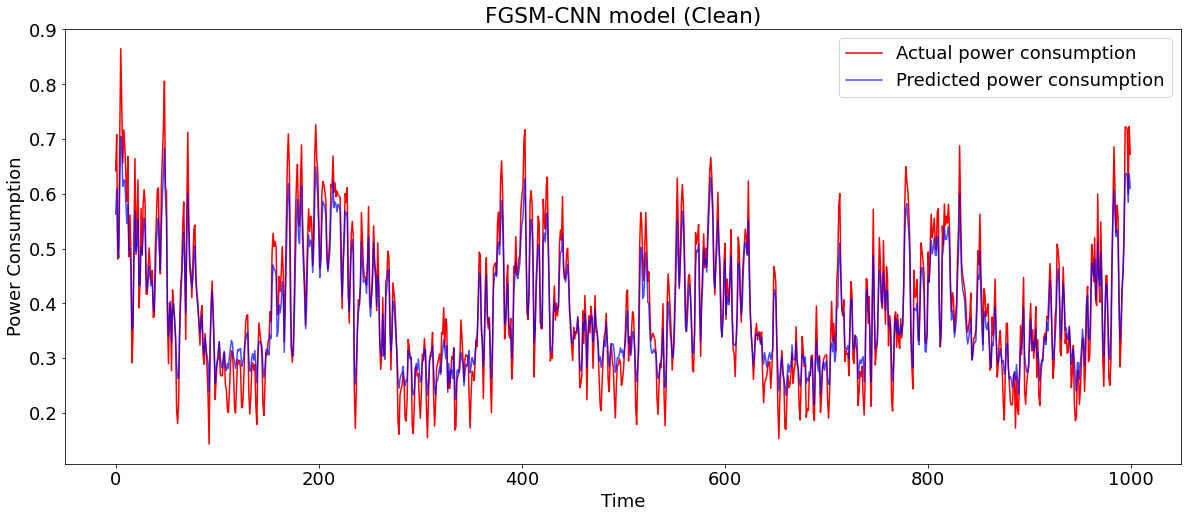

In [89]:
cnn_fgsm_predictions=get_result(fgsm_cnn, X_test, y_test, "FGSM-CNN")
plot_predictions(y_test, cnn_fgsm_predictions, "FGSM-CNN model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - FGSM-CNN:
R^2 Score: 0.9220866633112712
RMSE: 0.035582305207780336


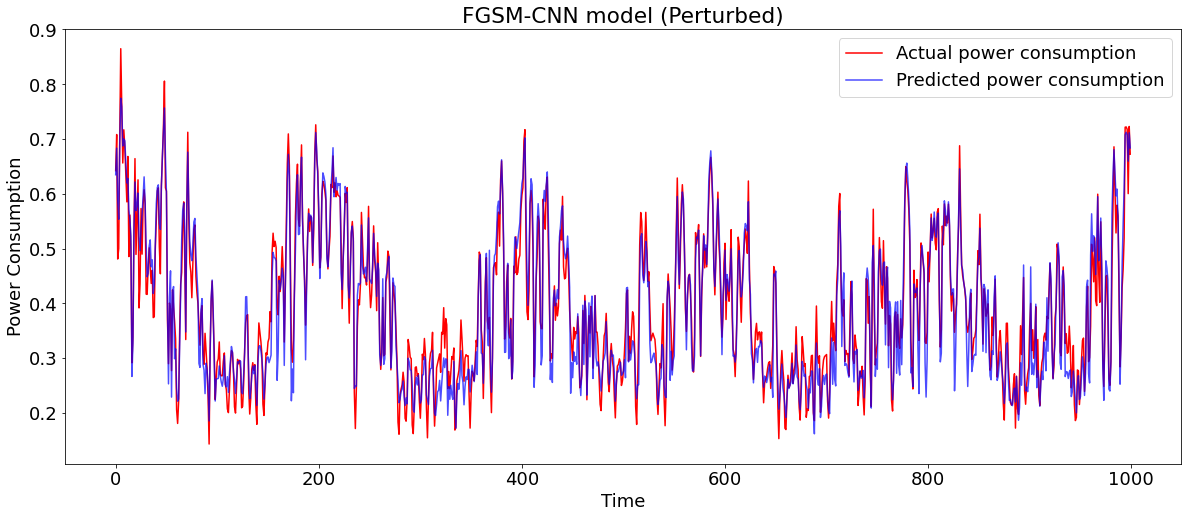

In [90]:
cnn_fgsm_predictions=get_result(fgsm_cnn, X_fgsm_perturbed_cnn, y_test, "FGSM-CNN")
plot_predictions(y_test, cnn_fgsm_predictions, "FGSM-CNN model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

In [91]:
# Create perturbed training set
X_bim_perturbed_train = bim(5,0.1,0.05,X_train, y_train)
X_new_cnn=np.concatenate((X_train,X_bim_perturbed_train))
bim_cnn=cnn(X_new_cnn,new_Y)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 22, 64)            192       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 11, 64)           0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 704)               0         
                                                                 
 dense_22 (Dense)            (None, 10)                7050      
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                                 
Total params: 7,253
Trainable params: 7,253
Non-trainable params: 0
___________________________________________________

Model - BIM-CNN:
R^2 Score: 0.9555443124516758
RMSE: 0.026877683424815075


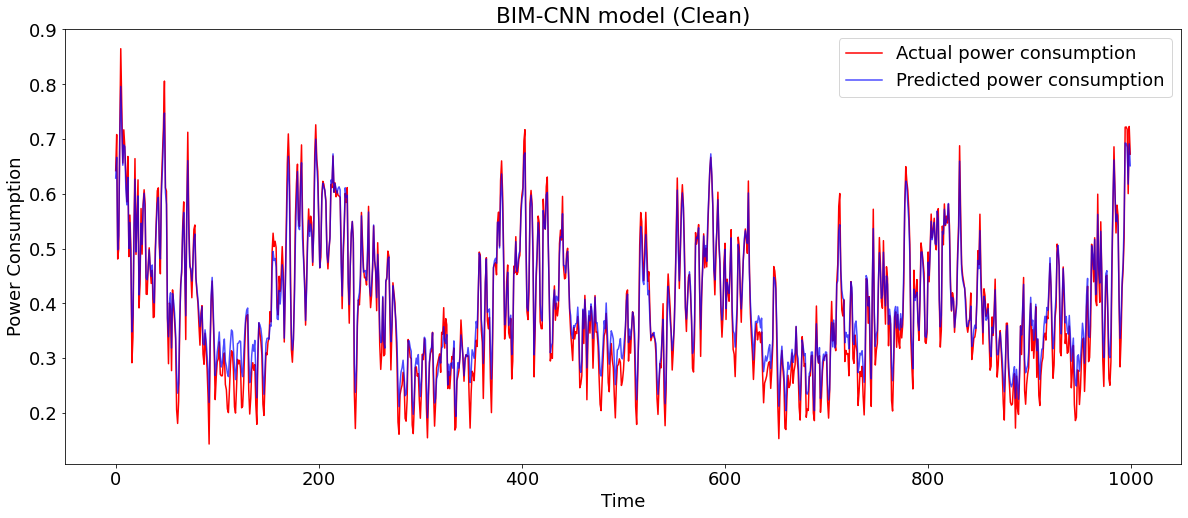

In [92]:
cnn_bim_predictions=get_result(bim_cnn, X_test, y_test, "BIM-CNN")
plot_predictions(y_test, cnn_bim_predictions, "BIM-CNN model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - BIM-CNN:
R^2 Score: 0.9466697988630302
RMSE: 0.029438439712589932


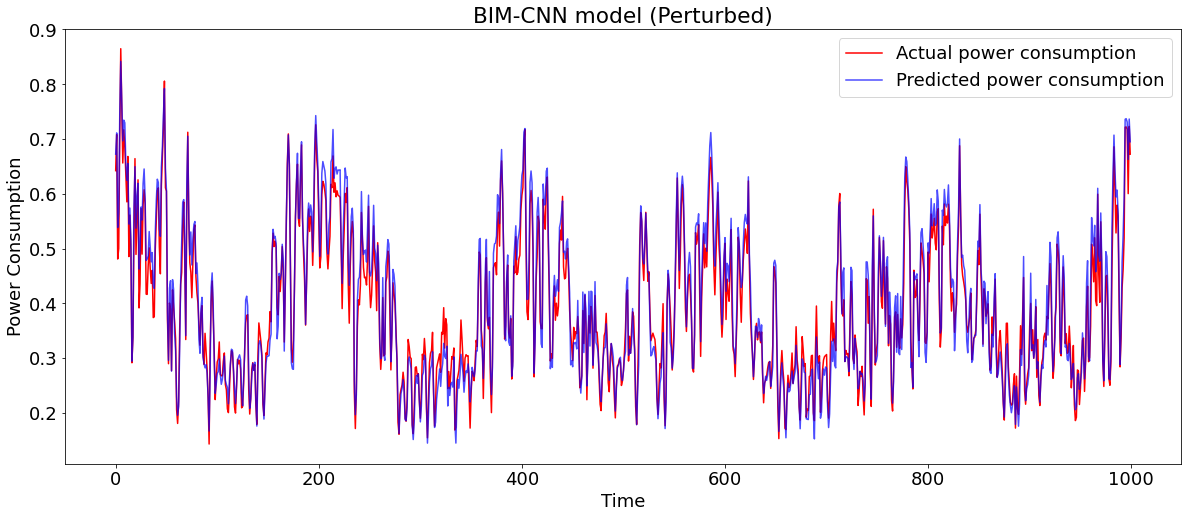

In [93]:
cnn_bim_predictions=get_result(bim_cnn, X_bim_perturbed_cnn, y_test, "BIM-CNN")
plot_predictions(y_test, cnn_bim_predictions, "BIM-CNN model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

In [94]:
# Create perturbed training set
X_pgd_perturbed_train = pgd(5,0.1,0.05,X_train, y_train)
X_new_cnn=np.concatenate((X_train,X_pgd_perturbed_train))
pgd_cnn=cnn(X_new_cnn,new_Y)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 22, 64)            192       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 11, 64)           0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 704)               0         
                                                                 
 dense_24 (Dense)            (None, 10)                7050      
                                                                 
 dense_25 (Dense)            (None, 1)                 11        
                                                                 
Total params: 7,253
Trainable params: 7,253
Non-trainable params: 0
___________________________________________________

Model - PGD-CNN:
R^2 Score: 0.9484640417580064
RMSE: 0.028938988401444665


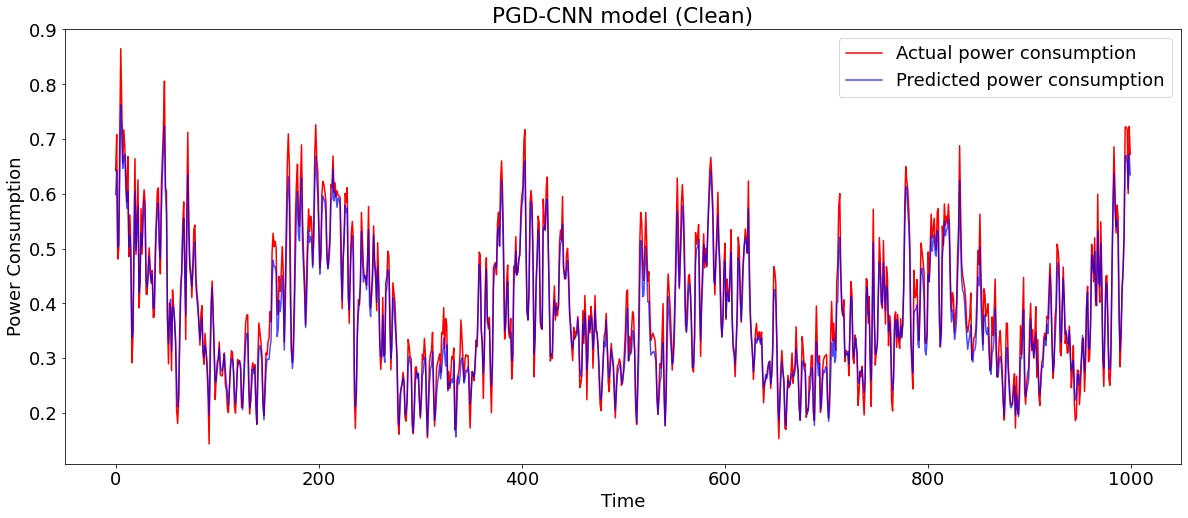

In [95]:
cnn_pgd_predictions=get_result(pgd_cnn, X_test, y_test, "PGD-CNN")
plot_predictions(y_test, cnn_pgd_predictions, "PGD-CNN model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - PGD-CNN:
R^2 Score: 0.8807073952051332
RMSE: 0.044028604569352515


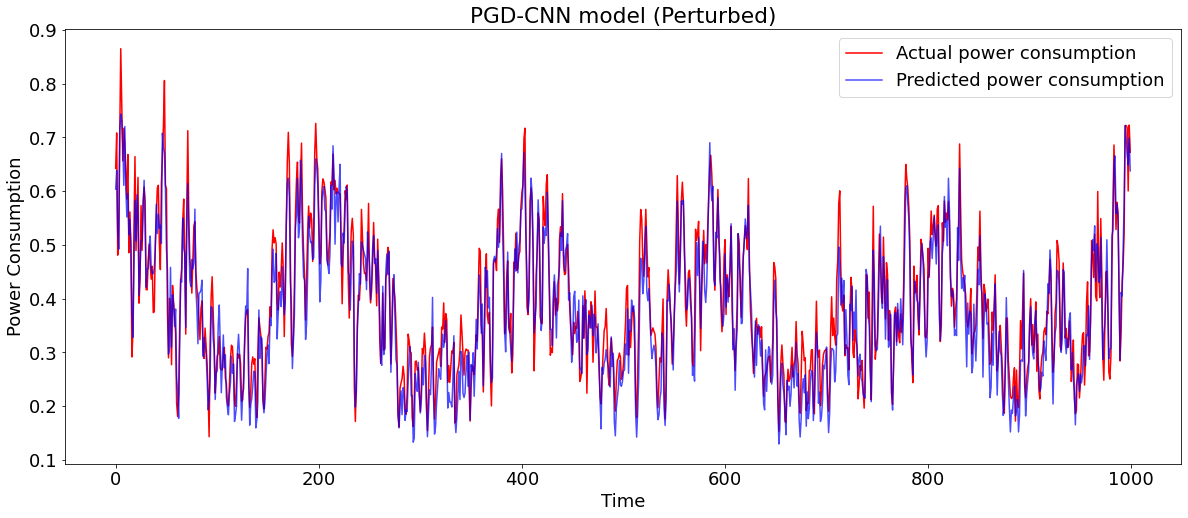

In [96]:
cnn_pgd_predictions=get_result(pgd_cnn, X_pgd_perturbed_cnn, y_test, "PGD-CNN")
plot_predictions(y_test, cnn_pgd_predictions, "PGD-CNN model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

#### CNN_LSTM

In [97]:
# Create perturbed training set
X_fgsm_perturbed_train = fgsm(X_train, y_train, epsilon=0.1)
X_new_cnnlstm=np.concatenate((X_train,X_fgsm_perturbed_train))
fgsm_cnnlstm=cnn_lstm(X_new_cnnlstm,new_Y)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, None, 23, 64)     128       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 11, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, None, 704)        0         
 tributed)                                                       
                                                                 
 lstm_13 (LSTM)              (None, 20)                58000     
                                                                 
 dense_26 (Dense)            (None, 1)                 21        
                                                     

Model - CNN-LSTM:
R^2 Score: 0.90176196597065
RMSE: 0.03995471303645938


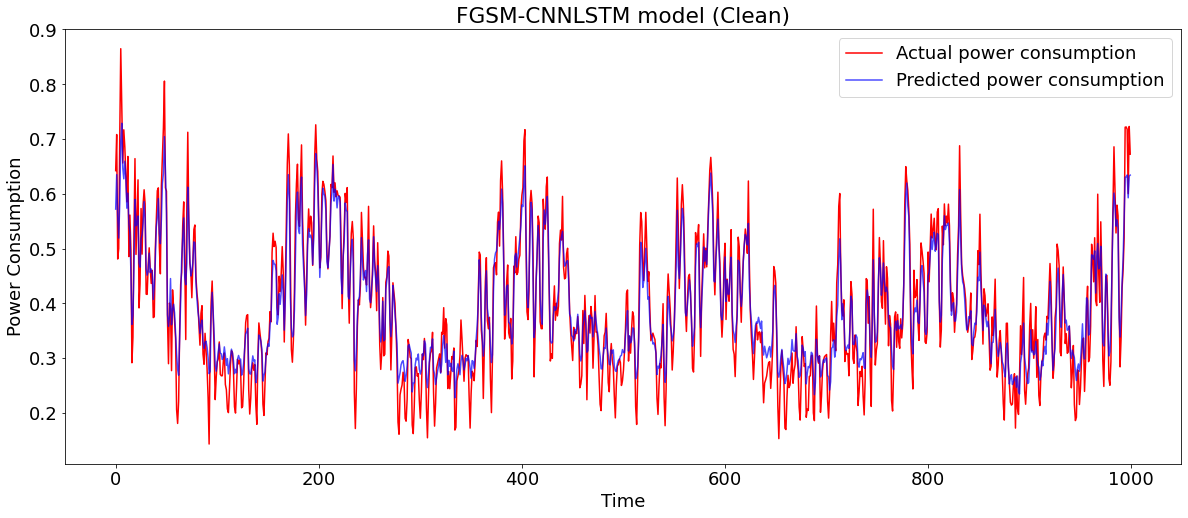

In [98]:
cnnlstm_fgsm_predictions=get_result(fgsm_cnnlstm, X_test.reshape((X_test.shape[0], n_seq, X_test.shape[1], 1)), y_test, "CNN-LSTM")
plot_predictions(y_test, cnnlstm_fgsm_predictions, "FGSM-CNNLSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - CNN-LSTM:
R^2 Score: 0.8900497337356414
RMSE: 0.04226942226668014


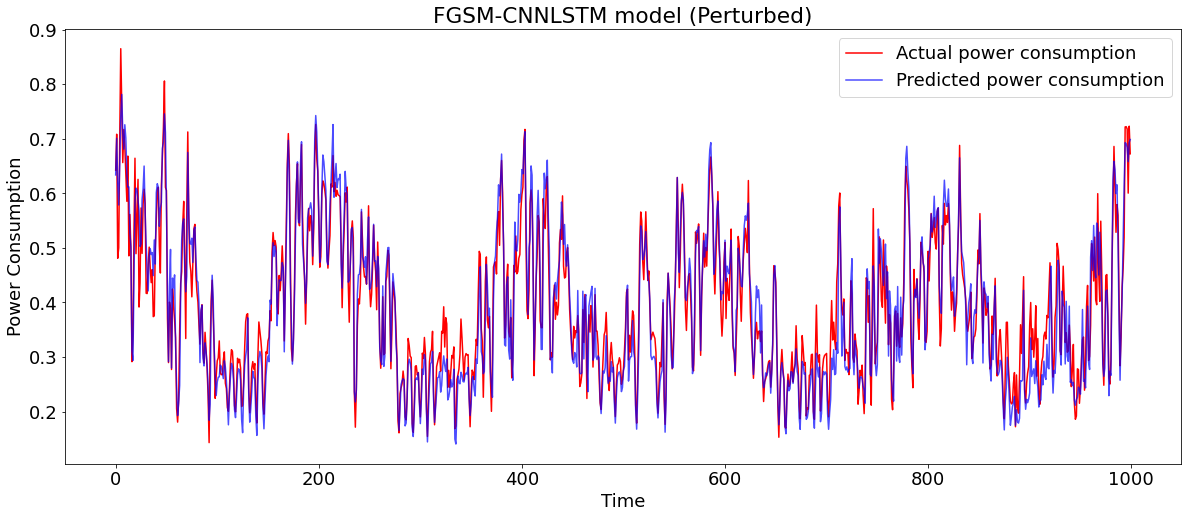

In [99]:
cnnlstm_fgsm_predictions=get_result(fgsm_cnnlstm, X_fgsm_perturbed_cnnlstm.reshape((X_fgsm_perturbed_cnnlstm.shape[0], n_seq, X_bim_perturbed_cnnlstm.shape[1], 1)), y_test, "CNN-LSTM")
plot_predictions(y_test, cnnlstm_fgsm_predictions, "FGSM-CNNLSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

In [100]:
# Create perturbed training set
X_bim_perturbed_train = bim(5,0.1,0.05,X_train, y_train)
X_new_cnnlstm=np.concatenate((X_train,X_bim_perturbed_train))
bim_cnnlstm=cnn_lstm(X_new_cnnlstm,new_Y)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, None, 23, 64)     128       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, None, 11, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, None, 704)        0         
 tributed)                                                       
                                                                 
 lstm_14 (LSTM)              (None, 20)                58000     
                                                                 
 dense_27 (Dense)            (None, 1)                 21        
                                                     

Model - CNN-LSTM:
R^2 Score: 0.9304330447836945
RMSE: 0.033622474227890504


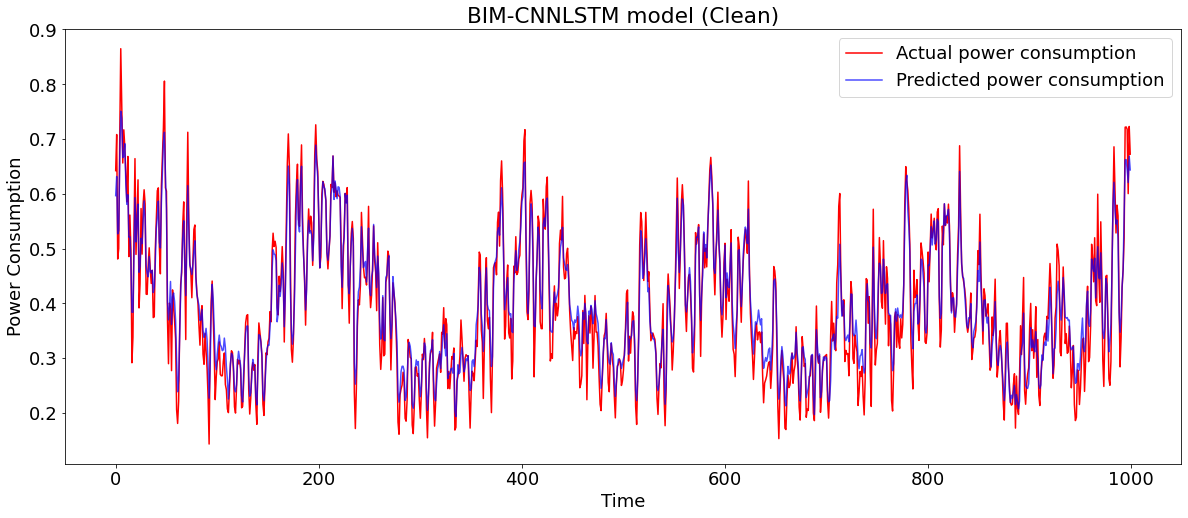

In [101]:
cnnlstm_bim_predictions=get_result(bim_cnnlstm, X_test.reshape((X_test.shape[0], n_seq, X_test.shape[1], 1)), y_test, "CNN-LSTM")
plot_predictions(y_test, cnnlstm_bim_predictions, "BIM-CNNLSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - CNN-LSTM:
R^2 Score: 0.9020602429736759
RMSE: 0.039894009894797876


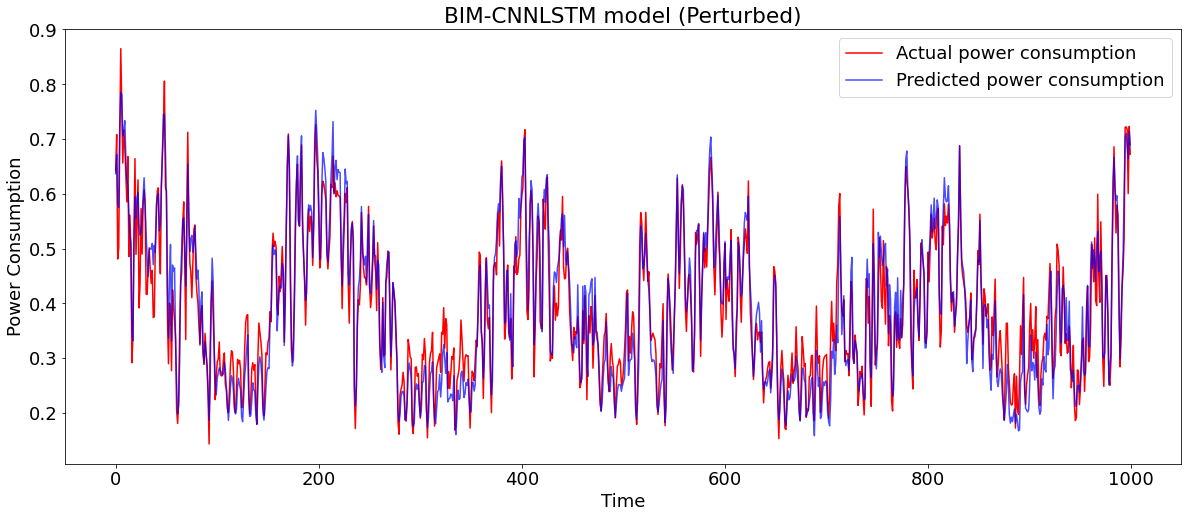

In [102]:
cnnlstm_bim_predictions=get_result(bim_cnnlstm, X_bim_perturbed_cnnlstm.reshape((X_bim_perturbed_cnnlstm.shape[0], n_seq, X_bim_perturbed_cnnlstm.shape[1], 1)), y_test, "CNN-LSTM")
plot_predictions(y_test, cnnlstm_bim_predictions, "BIM-CNNLSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

In [103]:
# Create perturbed training set
X_pgd_perturbed_train = pgd(5,0.1,0.05,X_train, y_train)
X_new_cnnlstm=np.concatenate((X_train,X_pgd_perturbed_train))
pgd_cnnlstm=cnn_lstm(X_new_cnnlstm,new_Y)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, None, 23, 64)     128       
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, None, 11, 64)     0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, None, 704)        0         
 stributed)                                                      
                                                                 
 lstm_15 (LSTM)              (None, 20)                58000     
                                                                 
 dense_28 (Dense)            (None, 1)                 21        
                                                     

Model - CNN-LSTM:
R^2 Score: 0.9433598447305176
RMSE: 0.030338241066760068


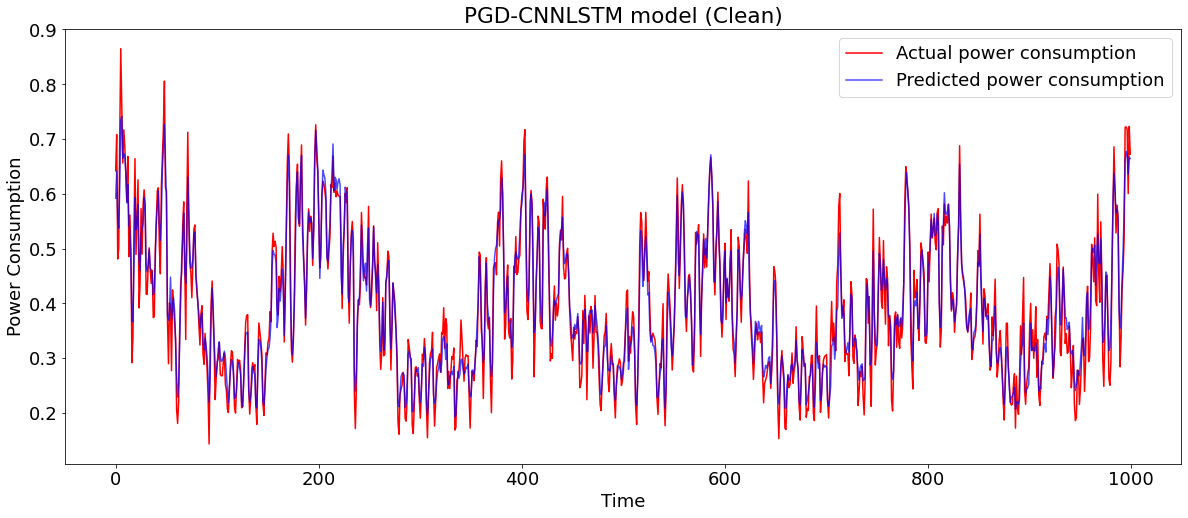

In [104]:
cnnlstm_pgd_predictions=get_result(pgd_cnnlstm, X_test.reshape((X_test.shape[0], n_seq, X_test.shape[1], 1)), y_test, "CNN-LSTM")
plot_predictions(y_test, cnnlstm_pgd_predictions, "PGD-CNNLSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - CNN-LSTM:
R^2 Score: 0.8849486387650433
RMSE: 0.04323884217055843


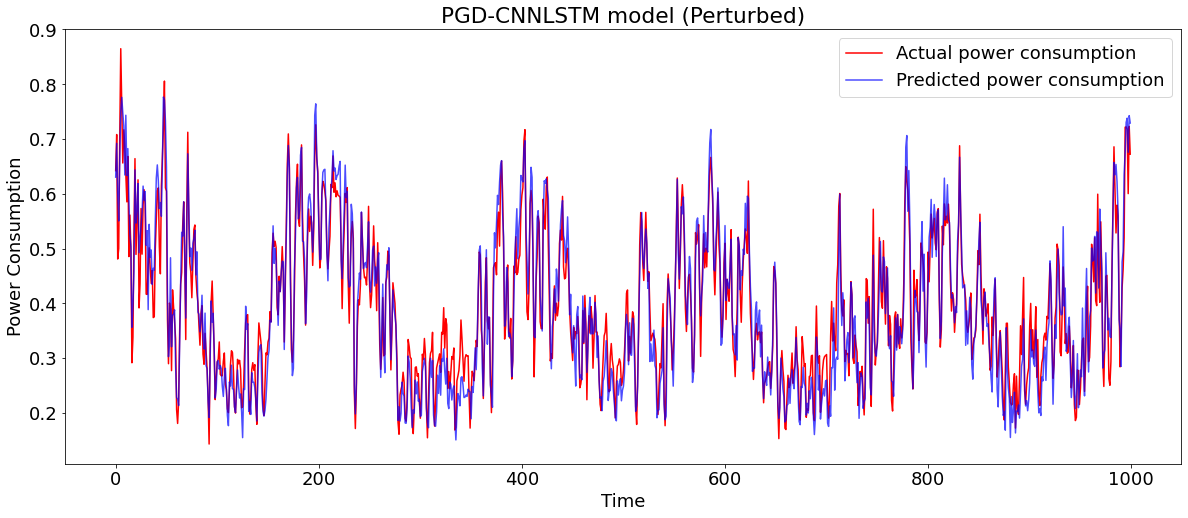

In [105]:
cnnlstm_pgd_predictions=get_result(pgd_cnnlstm, X_pgd_perturbed_cnnlstm.reshape((X_pgd_perturbed_cnnlstm.shape[0], n_seq, X_pgd_perturbed_cnnlstm.shape[1], 1)), y_test, "CNN-LSTM")
plot_predictions(y_test, cnnlstm_pgd_predictions, "PGD-CNNLSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

#### ConvLSTM

In [106]:
# Create perturbed training set
X_fgsm_perturbed_train = fgsm(X_train, y_train, epsilon=0.1)
X_new_convlstm=np.concatenate((X_train,X_fgsm_perturbed_train))
fgsm_convlstm=convlstm(X_new_convlstm,new_Y)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 22, 64)         33536     
                                                                 
 flatten_9 (Flatten)         (None, 1408)              0         
                                                                 
 dense_29 (Dense)            (None, 1)                 1409      
                                                                 
Total params: 34,945
Trainable params: 34,945
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
254/254 [==============================] - 4s 6ms/step - loss: 0.0168
Epoch 2/10
254/254 [==============================] - 1s 6ms/step - loss: 0.0035
Epoch 3/10
254/254 [==============================] - 2s 6ms/step - loss: 0.0030
Epoch 4/10
254/254 [==============================] - 2s 6ms/step - lo

Model - ConvLSTM:
R^2 Score: 0.9065115221483124
RMSE: 0.03897689290049064


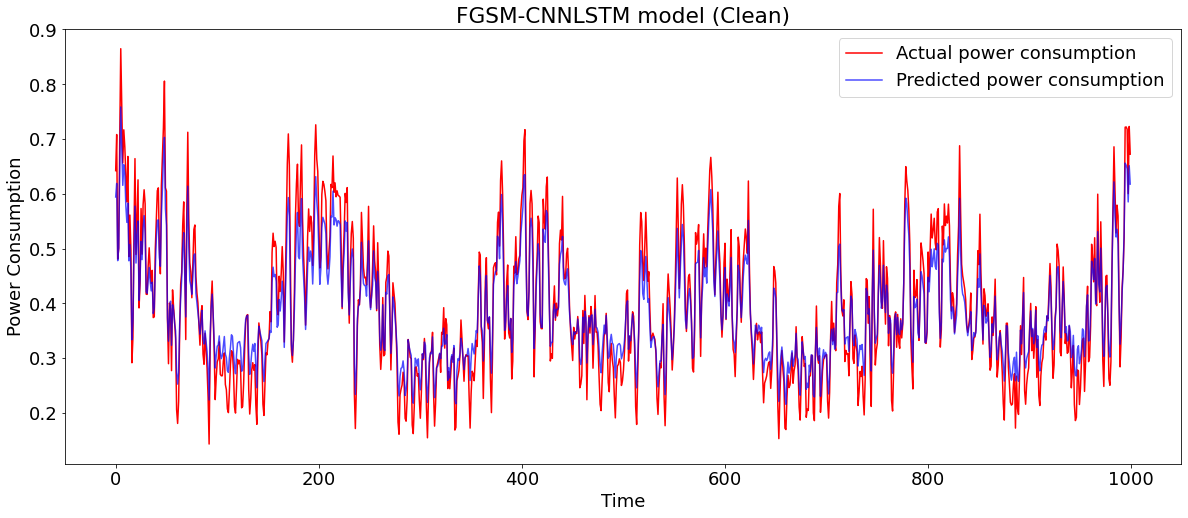

In [107]:
convlstm_fgsm_predictions=get_result(fgsm_convlstm, X_test.reshape((X_test.shape[0], n_seq,1, X_test.shape[1], 1)), y_test, "ConvLSTM")
plot_predictions(y_test, convlstm_fgsm_predictions, "FGSM-CNNLSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - ConvLSTM:
R^2 Score: 0.9082580055913656
RMSE: 0.03861110619625878


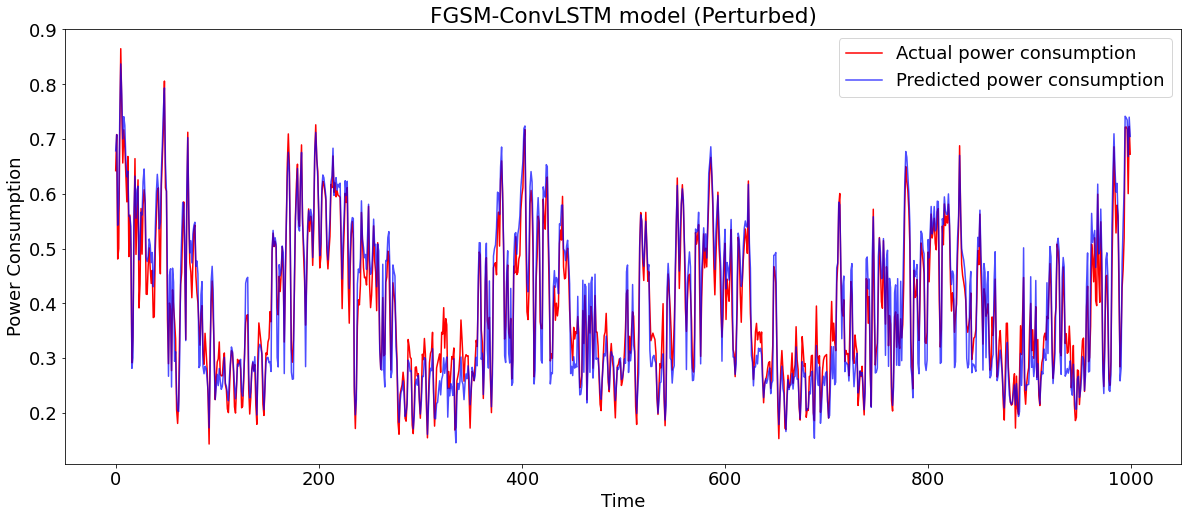

In [108]:
convlstm_fgsm_predictions=get_result(fgsm_convlstm, X_fgsm_perturbed_convlstm.reshape((X_fgsm_perturbed_convlstm.shape[0], n_seq,1, X_bim_perturbed_convlstm.shape[1], 1)), y_test, "ConvLSTM")
plot_predictions(y_test, convlstm_fgsm_predictions, "FGSM-ConvLSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

In [109]:
# Create perturbed training set
X_bim_perturbed_train = bim(5,0.1,0.05,X_train, y_train)
X_new_convlstm=np.concatenate((X_train,X_bim_perturbed_train))
bim_convlstm=convlstm(X_new_convlstm,new_Y)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 1, 22, 64)         33536     
                                                                 
 flatten_10 (Flatten)        (None, 1408)              0         
                                                                 
 dense_30 (Dense)            (None, 1)                 1409      
                                                                 
Total params: 34,945
Trainable params: 34,945
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
254/254 [==============================] - 4s 6ms/step - loss: 0.0176
Epoch 2/10
254/254 [==============================] - 2s 6ms/step - loss: 0.0024
Epoch 3/10
254/254 [==============================] - 1s 6ms/step - loss: 0.0018
Epoch 4/10
254/254 [==============================] - 1s 5ms/step - lo

Model - ConvLSTM:
R^2 Score: 0.9433543856427704
RMSE: 0.03033970206334298


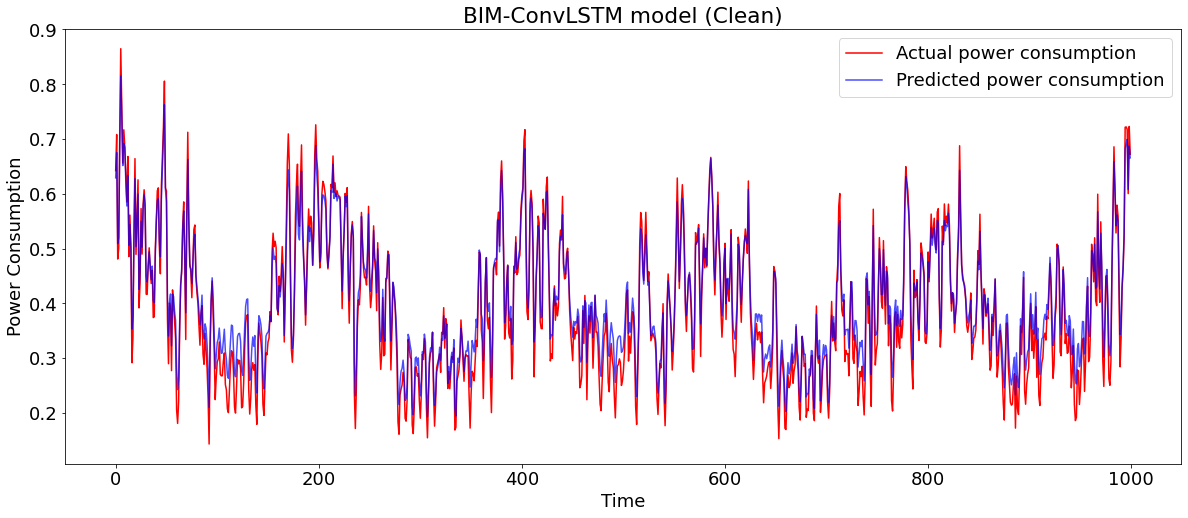

In [110]:
convlstm_bim_predictions=get_result(bim_convlstm, X_test.reshape((X_test.shape[0], n_seq,1, X_test.shape[1], 1)), y_test, "ConvLSTM")
plot_predictions(y_test, convlstm_bim_predictions, "BIM-ConvLSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - ConvLSTM:
R^2 Score: 0.9255767959578435
RMSE: 0.034776216404490946


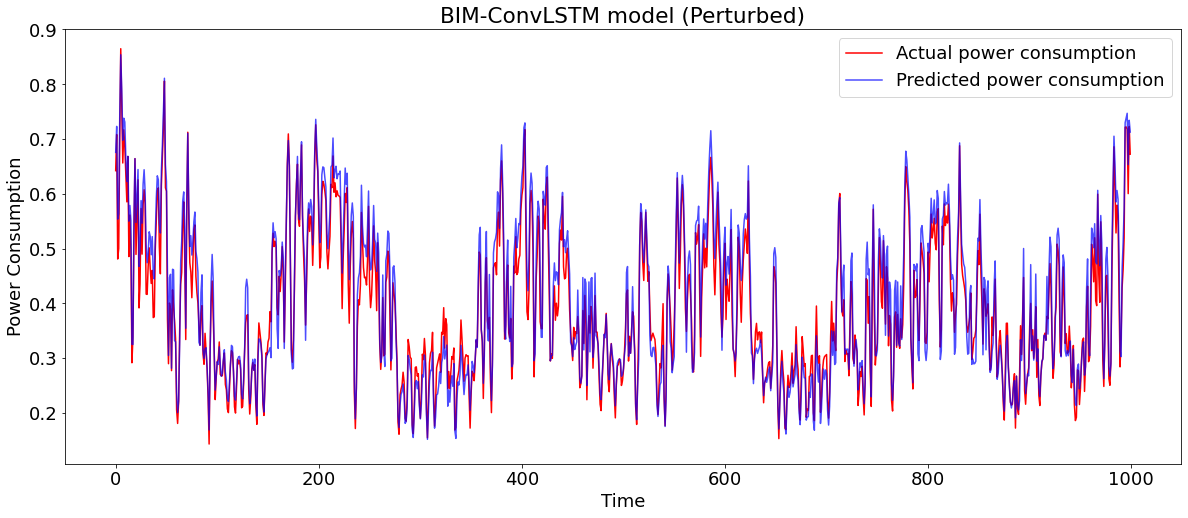

In [111]:
convlstm_bim_predictions=get_result(bim_convlstm, X_bim_perturbed_convlstm.reshape((X_bim_perturbed_convlstm.shape[0], n_seq,1, X_bim_perturbed_convlstm.shape[1], 1)), y_test, "ConvLSTM")
plot_predictions(y_test, convlstm_bim_predictions, "BIM-ConvLSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

In [112]:
X_pgd_perturbed_train = pgd(5,0.1,0.05,X_train, y_train)
X_new_convlstm=np.concatenate((X_train,X_pgd_perturbed_train))
pgd_convlstm=convlstm(X_new_convlstm,new_Y)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_3 (ConvLSTM2D)  (None, 1, 22, 64)         33536     
                                                                 
 flatten_11 (Flatten)        (None, 1408)              0         
                                                                 
 dense_31 (Dense)            (None, 1)                 1409      
                                                                 
Total params: 34,945
Trainable params: 34,945
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
254/254 [==============================] - 4s 5ms/step - loss: 0.0162
Epoch 2/10
254/254 [==============================] - 1s 5ms/step - loss: 0.0028
Epoch 3/10
254/254 [==============================] - 1s 5ms/step - loss: 0.0023
Epoch 4/10
254/254 [==============================] - 1s 5ms/step - lo

Model - ConvLSTM:
R^2 Score: 0.9548606614714878
RMSE: 0.027083560770903105


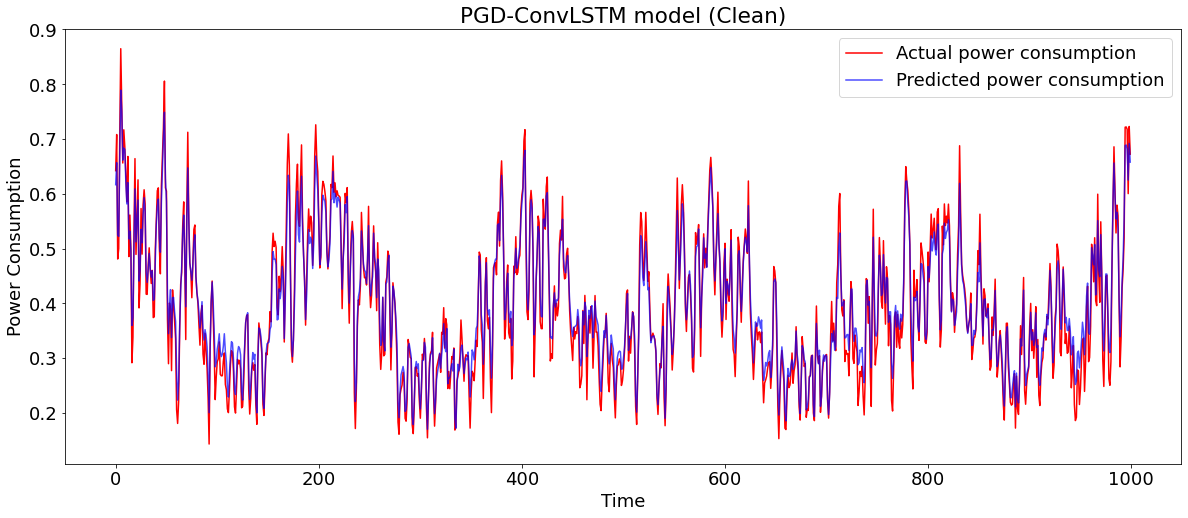

In [113]:
convlstm_pgd_predictions=get_result(pgd_convlstm, X_test.reshape((X_test.shape[0], n_seq,1, X_test.shape[1], 1)), y_test, "ConvLSTM")
plot_predictions(y_test, convlstm_pgd_predictions, "PGD-ConvLSTM model (Clean)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")

Model - ConvLSTM:
R^2 Score: 0.8646423743587545
RMSE: 0.04689964252676415


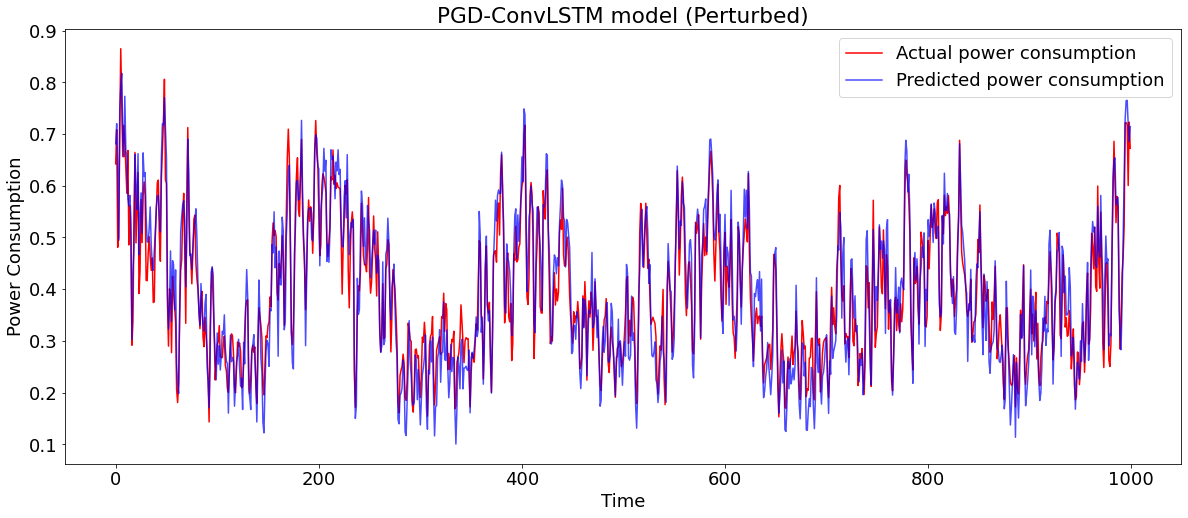

In [114]:
convlstm_pgd_predictions=get_result(pgd_convlstm, X_pgd_perturbed_convlstm.reshape((X_pgd_perturbed_convlstm.shape[0], n_seq,1, X_pgd_perturbed_convlstm.shape[1], 1)), y_test, "ConvLSTM")
plot_predictions(y_test, convlstm_pgd_predictions, "PGD-ConvLSTM model (Perturbed)", xLabel="Time", yLabel="Power Consumption", realLabel="Actual power consumption", predictedLabel="Predicted power consumption")